# Vehicle Detection using TensorFlow
#Functions include: 
#1) detect vehicle from still picture, 2) output the number of vehicles detected, 3) detect vehicle from video clip

In [1]:
# Jobs include: 
# 1) detect vehicle from still picture, 2) output the number of vehicles detected.
# 3) detect vehicle from video

In [1]:
import os, sys
import math
import numpy as np
import tensorflow as tf
import cv2
from PIL import Image, PILLOW_VERSION

slim = tf.contrib.slim

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as mpcm

In [3]:
colors_tableau = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
                 (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
                 (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
                 (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
                 (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

In [4]:
isess = tf.InteractiveSession()

# Drawing and plotting routines.

In [5]:
def bboxes_draw_on_img(img, scores, bboxes, colors, thickness=2, show_text=True):
    """Drawing bounding boxes on an image, with additional text if wanted...
    """
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[i % len(colors)]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        if show_text:
            s = '%s: %s' % ('Car', scores[i])    
            p1 = (p1[0]-5, p1[1])
            cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.7, color, 1)
        
def plot_image(img, title='', figsize=(24, 9)):
    f, axes = plt.subplots(1, 1, figsize=figsize)
    f.tight_layout()
    axes.imshow(img)
    axes.set_title(title, fontsize=20)

# SSD TensorFlow Network

Build up the convolutional network and load the checkpoint.

In [6]:
from nets import ssd_vgg_300
from nets import ssd_common
from preprocessing import ssd_vgg_preprocessing

#ckpt_filename = './checkpoints/model.ckpt-5181'
ckpt_filename = './checkpoints/ssd_model.ckpt'

In [7]:
# Input placeholder.
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, (None, None), resize=ssd_vgg_preprocessing.Resize.NONE)
image_4d = tf.expand_dims(image_pre, 0)

# Network parameters.
params = ssd_vgg_300.SSDNet.default_params
params = params._replace(num_classes=8)

# SSD network construction.
reuse = True if 'ssd' in locals() else None
ssd = ssd_vgg_300.SSDNet(params)
with slim.arg_scope(ssd.arg_scope(weight_decay=0.0005)):
    predictions, localisations, logits, end_points = ssd.net(image_4d, is_training=False, reuse=reuse)

In [8]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)

# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)
# Save back model to clean the checkpoint
save_clean = False
if save_clean:
    ckpt_filename_save = './checkpoints/ssd_model.ckpt'
    saver.save(isess, ckpt_filename_save, write_meta_graph=True, write_state=True)

INFO:tensorflow:Restoring parameters from ./checkpoints/ssd_model.ckpt


# Image Pipeline

Presenting the different steps of the vehicle detection pipeline.

In [9]:
# Main SSD processing routine.
def ssd_process_image(img, select_threshold=0.5):
    """Process an image through SSD network.
    
    Arguments:
      img: Numpy array containing an image.
      select_threshold: Classification threshold (i.e. probability threshold for car detection).
    Return:
      rclasses, rscores, rbboxes: Classes, scores and bboxes of objects detected.
    """
    # Resize image to height 300.
    factor = 300. / float(img.shape[0])
    img = cv2.resize(img, (0,0), fx=factor, fy=factor) 
    # Run SSD network and get class prediction and localization.
    rpredictions, rlocalisations = isess.run([predictions, localisations], feed_dict={img_input: img})
    
    # Get anchor boxes for this image shape.
    ssd.update_feature_shapes(rpredictions)
    anchors = ssd.anchors(img.shape, dtype=np.float32)
    
    # Compute classes and bboxes from the net outputs: decode SSD output.
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            threshold=select_threshold, img_shape=img.shape, num_classes=ssd.params.num_classes, decode=True)
    
    # Remove other classes than cars.
    idxes = (rclasses == 1)
    rclasses = rclasses[idxes]
    rscores = rscores[idxes]
    rbboxes = rbboxes[idxes]
    # Sort boxes by score.
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, top_k=400, priority_inside=True, margin=0.0)
    return rclasses, rscores, rbboxes

## Load sample image

Shape: (480, 640, 3)
Shape: (480, 640, 3)
Shape: (480, 640, 3)
Shape: (2448, 3264, 3)
Shape: (2448, 3264, 3)
Shape: (2448, 3264, 3)
Shape: (720, 1280, 3)


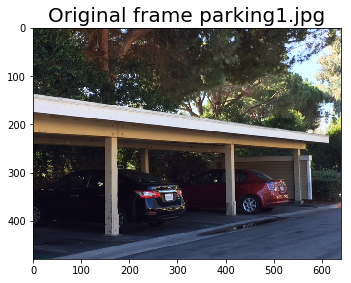

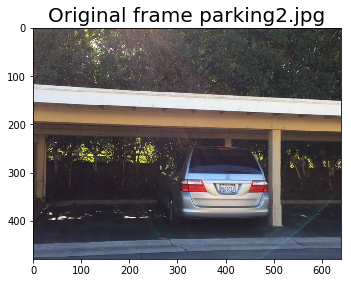

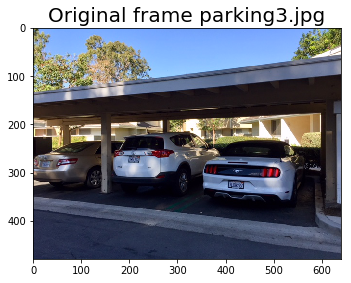

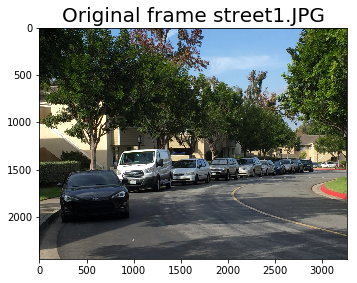

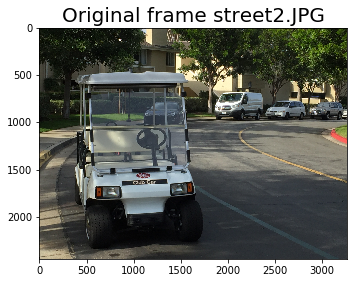

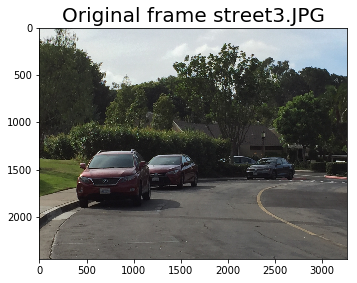

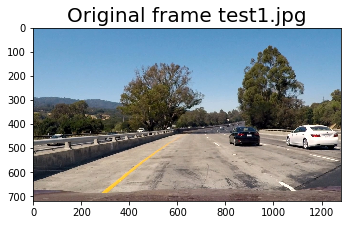

In [10]:
# Load a sample image.
path = 'test_images/'
image_names = sorted(os.listdir(path))
img = []
i = 1
while ((image_names) and (i<8)):
    img = mpimg.imread(path + image_names[i])
    #img = mpimg.imread(os.path.join(path, file))
    print('Shape:', img.shape)
    plot_image(img, 'Original frame '+ image_names[i], (5, 5))
    i += 1

## Raw SSD output: multiple detections after simple thresholding

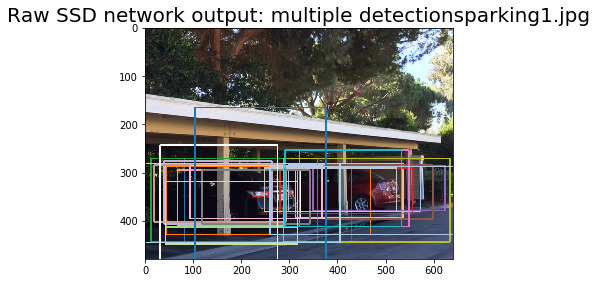

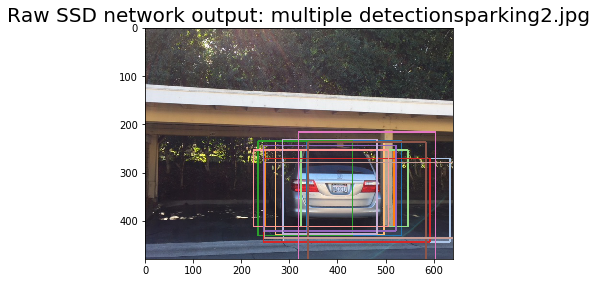

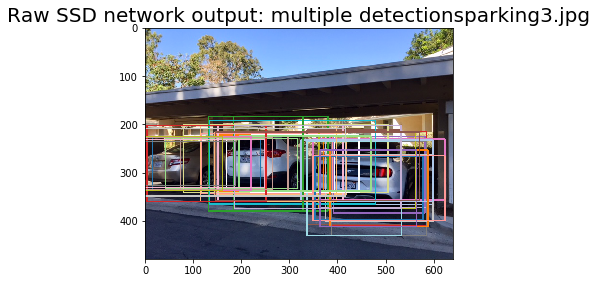

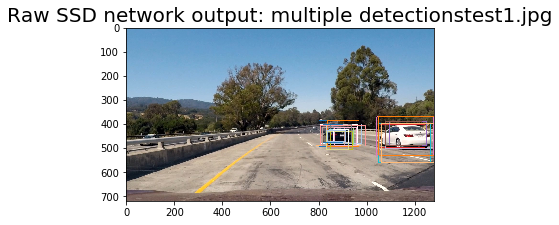

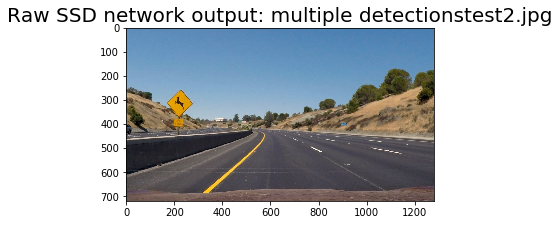

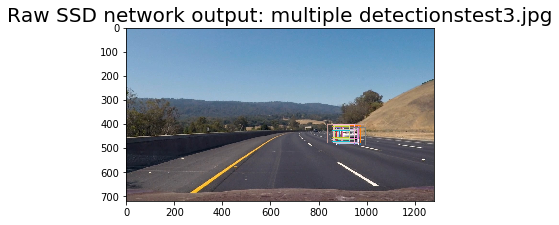

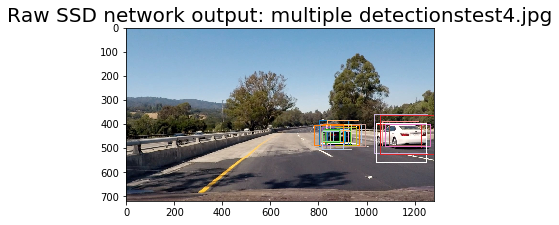

In [23]:
path = 'test_images/'
image_names = sorted(os.listdir(path))
i=1
while ((image_names) and (i<8)):
    # SSD network on image.
    img = mpimg.imread(path + image_names[i])
    rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold=0.8)
    # Draw bboxes of detected objects.
    img_bboxes = np.copy(img)
    bboxes_draw_on_img(img_bboxes, rscores, rbboxes, colors_tableau, thickness=2, show_text=False)
    #print(rbboxes)

    plot_image(img_bboxes, 'Raw SSD network output: multiple detections'+ image_names[i], (5, 5))
    i+=1

In [24]:
def bboxes_overlap(bbox, bboxes):
    """Computing overlap score between bboxes1 and bboxes2.
    Note: bboxes1 can be multi-dimensional.
    """
    if bboxes.ndim == 1:
        bboxes = np.expand_dims(bboxes, 0)
    # Intersection bbox and volume.
    int_ymin = np.maximum(bboxes[:, 0], bbox[0])
    int_xmin = np.maximum(bboxes[:, 1], bbox[1])
    int_ymax = np.minimum(bboxes[:, 2], bbox[2])
    int_xmax = np.minimum(bboxes[:, 3], bbox[3])

    int_h = np.maximum(int_ymax - int_ymin, 0.)
    int_w = np.maximum(int_xmax - int_xmin, 0.)
    int_vol = int_h * int_w
    # Union volume.
    vol1 = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
    vol2 = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    score1 = int_vol / vol1
    score2 = int_vol / vol2
    return np.maximum(score1, score2)


def bboxes_nms_intersection_avg(classes, scores, bboxes, threshold=0.5):
    """Apply non-maximum selection to bounding boxes with score averaging.
    The NMS algorithm works as follows: go over the list of boxes, and for each, see if
    boxes with lower score overlap. If yes, averaging their scores and coordinates, and
    consider it as a valid detection.
    
    Arguments:
      classes, scores, bboxes: SSD network output.
      threshold: Overlapping threshold between two boxes.
    Return:
      classes, scores, bboxes: Classes, scores and bboxes of objects detected after applying NMS.
    """
    keep_bboxes = np.ones(scores.shape, dtype=np.bool)
    new_bboxes = np.copy(bboxes)
    new_scores = np.copy(scores)
    new_elements = np.ones_like(scores)
    for i in range(scores.size-1):
        if keep_bboxes[i]:
            # Computer overlap with bboxes which are following.
            sub_bboxes = bboxes[(i+1):]
            sub_scores = scores[(i+1):]
            overlap = bboxes_overlap(new_bboxes[i], sub_bboxes)
            mask = np.logical_and(overlap > threshold, keep_bboxes[(i+1):])
            while np.sum(mask):
                keep_bboxes[(i+1):] = np.logical_and(keep_bboxes[(i+1):], ~mask)
                # Update boxes...
                tmp_scores = np.reshape(sub_scores[mask], (sub_scores[mask].size, 1))
                new_bboxes[i] = new_bboxes[i] * new_scores[i] + np.sum(sub_bboxes[mask] * tmp_scores, axis=0)
                new_scores[i] += np.sum(sub_scores[mask])
                new_bboxes[i] = new_bboxes[i] / new_scores[i]
                new_elements[i] += np.sum(mask)
                
                # New overlap with the remaining?
                overlap = bboxes_overlap(new_bboxes[i], sub_bboxes)
                mask = np.logical_and(overlap > threshold, keep_bboxes[(i+1):])

    new_scores = new_scores / new_elements
    idxes = np.where(keep_bboxes)
    return classes[idxes], new_scores[idxes], new_bboxes[idxes]

number of car detected:  11


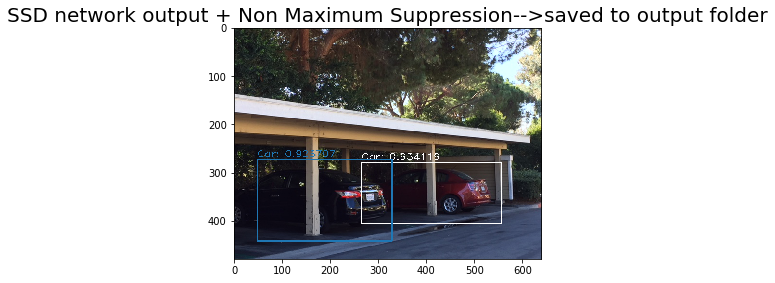

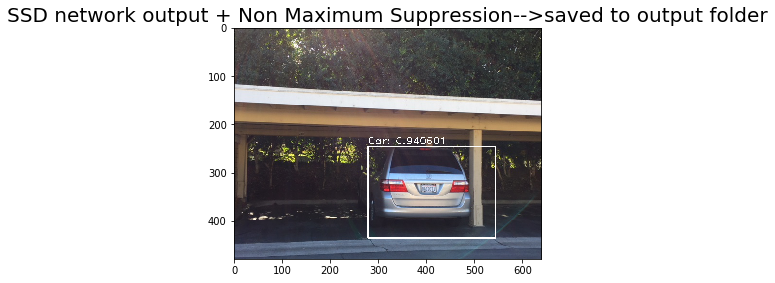

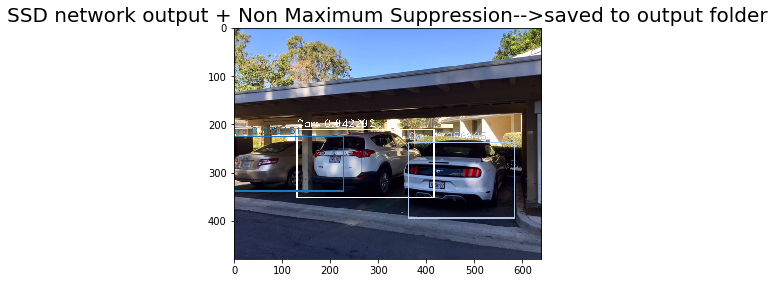

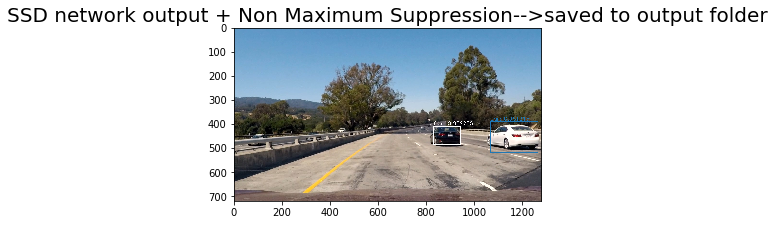

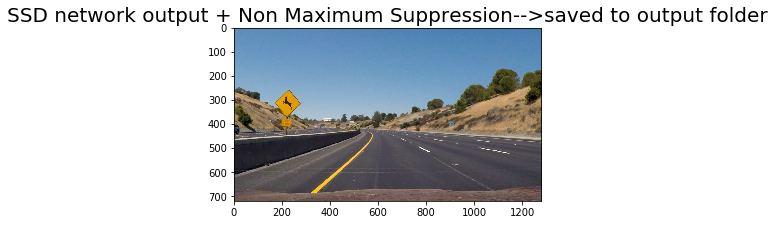

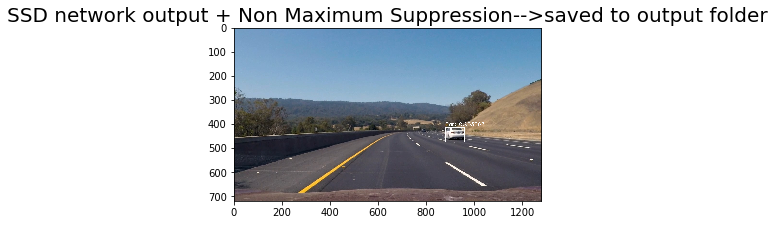

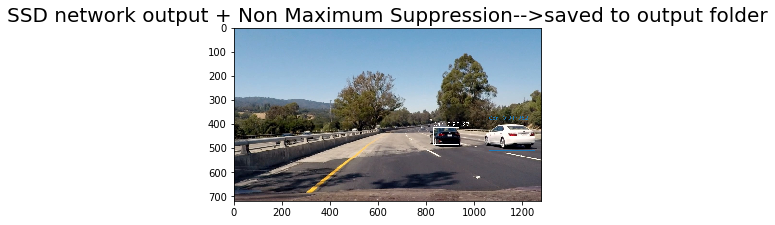

In [25]:
def process_image(img, select_threshold=0.8, nms_threshold=0.5):
    # SSD network + NMS on image.
    rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold)
    rclasses, rscores, rbboxes = bboxes_nms_intersection_avg(rclasses, rscores, rbboxes, threshold=nms_threshold)
    # Draw bboxes of detected objects.
    bboxes_draw_on_img(img, rscores, rbboxes, colors_tableau, thickness=2, show_text=True)
    return img

#Raw SSD output:
path = 'test_images/'
image_names = sorted(os.listdir(path))
i=1
#initialize the number of car detected
num_car = 0
while ((image_names) and (i<8)):
    # SSD network on image.
    img = mpimg.imread(path + image_names[i])
    rclasses, rscores, rbboxes = ssd_process_image(img, select_threshold=0.8)
    # Draw bboxes of detected objects.
    img_bboxes = np.copy(img)
    bboxes_draw_on_img(img_bboxes, rscores, rbboxes, colors_tableau, thickness=2, show_text=False)
    #print(rbboxes)

    #plot_image(img_bboxes, 'Raw SSD network output: multiple detections'+ image_names[i], (5, 5))
    # Apply Non-Maximum-Selection
    nms_threshold = 0.5
    rclasses_nms, rscores_nms, rbboxes_nms = bboxes_nms_intersection_avg(rclasses, rscores, rbboxes, threshold=nms_threshold)

    #output image drawing to an output folder:
    outpath = 'output_images/'
    
    # SSD network on image.
    img = mpimg.imread(path + image_names[i])
    img_bboxes = np.copy(img)
    bboxes_draw_on_img(img_bboxes, rscores_nms, rbboxes_nms, colors_tableau, thickness=2)
    
    num_car= num_car + rbboxes_nms.shape[0]
    
    img_out = process_image(img, select_threshold=0.8, nms_threshold=0.5)
    mpimg.imsave(outpath + image_names[i], img_out, format='jpg')
    plot_image(img_bboxes, 'SSD network output + Non Maximum Suppression-->saved to output folder', (5, 5))

    i+=1
print("number of car detected: ",num_car)

# Video Detection:

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import namedtuple

In [27]:
car = namedtuple('car', ['n_frames', 'bbox', 'speed', 'score', 'idx'])

def update_car_collection(cars, scores, bboxes, 
                          overlap_threshold=0.5, smoothing=0.3, n_frames=15):
    """Update a car collection.
    The algorithm works as follows: it first tries to match cars from the collection with
    new bounding boxes. For every match, the car coordinates and speed are updated accordingly.
    If there are remaining boxes at the end of the matching process, every one of them is considered
    as a new car.
    Finally, the algorithm also checks in how many of the last N frames the object has been detected.
    This allows to remove false positives, which usually only appear on a very few frames.
    
    Arguments:
      cars: List of car objects.
      scores, bboxes: Scores and boxes of newly detected objects.
    
    Return:
      cars collection updated.
    """
    detected_bboxes = np.zeros(scores.shape, dtype=np.bool)
    new_cars = []
    for i, c in enumerate(cars):
        # Car bbox prediction, using speed.
        cbbox = c.bbox + np.concatenate([c.speed] * 2)
        # Overlap with detected bboxes.
        overlap = bboxes_overlap(cbbox, bboxes)
        mask = np.logical_and(overlap > overlap_threshold, ~detected_bboxes)
        # Some detection overlap with prior.
        if np.sum(mask) > 0:
            detected_bboxes[mask] = True
            sub_scores = np.reshape(scores[mask], (scores[mask].size, 1))
            nbbox = np.sum(bboxes[mask] * sub_scores, axis=0) / np.sum(sub_scores)
            
            # Update car parameters.
            new_cbbox = smoothing * nbbox + (1 - smoothing) * cbbox
            nspeed = np.sum(np.reshape(new_cbbox - cbbox, (2, 2)), axis=0)
            new_speed = nspeed * smoothing + (1 - smoothing) * c.speed
            new_score = np.sum(sub_scores) / np.sum(mask)
            new_score = smoothing * new_score + (1 - smoothing) * c.score
            new_cars.append(car(n_frames=np.minimum(c.n_frames + 1, n_frames),
                                bbox=new_cbbox,
                                speed=new_speed,
                                score=new_score,
                                idx=c.idx))
        else:
            # Keep the same one, with just a position update.
            if c.n_frames > 1:
                new_cars.append(car(n_frames=c.n_frames-1,
                                    bbox=cbbox,
                                    speed=c.speed,
                                    score=c.score,
                                    idx=c.idx))
    max_idx = max([0] + [c.idx for c in new_cars]) + 1
    # Add remaining boxes.
    for i in range(scores.size):
        if not detected_bboxes[i]:
            new_cars.append(car(n_frames=1,
                                bbox=bboxes[i],
                                speed=np.zeros((2, ), dtype=bboxes.dtype),
                                score=scores[i],
                                idx=max_idx))
            max_idx += 1
    
    # Sort list of car by size.
    sorted(new_cars, key=lambda x: (x.bbox[2]-x.bbox[0]) * (x.bbox[3]-x.bbox[1]), reverse=True)
    return new_cars

In [34]:
def ssd_process_frame(img, select_threshold=0.5, nms_threshold=0.2, overlap_threshold=0.4, smoothing=0.25):
    """Process a video frame through SSD network, apply NMS algorithm and draw bounding boxes.
    
    Arguments:
      img: Numpy array containing an image.
      select_threshold: Classification threshold (i.e. probability threshold for car detection).
      nms_threshold: NMS threshold.
      overlap_threshold: Overlap threshold used for updating cars collection.
      smoothing: Smoothing factor over frames.
    Return:
      image with bounding boxes.
    """
    # Resize image to height 300.
    #factor = 300. / float(img.shape[0])
    #img = cv2.resize(img, (0,0), fx=factor, fy=factor) 
    # Run SSD network and get class prediction and localization.
    rpredictions, rlocalisations = isess.run([predictions, localisations], feed_dict={img_input: img})
    
    # Get anchor boxes for this image shape.
    ssd.update_feature_shapes(rpredictions)
    anchors = ssd.anchors(img.shape, dtype=np.float32)
    
    # Compute classes and bboxes from the net outputs: decode SSD output.
    rclasses, rscores, rbboxes, rlayers, ridxes = ssd_common.ssd_bboxes_select(
            rpredictions, rlocalisations, anchors,
            threshold=select_threshold, img_shape=img.shape, num_classes=ssd.params.num_classes, decode=True)
    
    # Remove other classes than cars.
    idxes = (rclasses == 1)
    rclasses = rclasses[idxes]
    rscores = rscores[idxes]
    rbboxes = rbboxes[idxes]
    # Sort boxes by score.
    rclasses, rscores, rbboxes = ssd_common.bboxes_sort(rclasses, rscores, rbboxes, 
                                                        top_k=400, priority_inside=True, margin=0.0)
    # Apply NMS.
    rclasses, rscores, rbboxes = bboxes_nms_intersection_avg(rclasses, rscores, rbboxes, 
                                                             threshold=nms_threshold)
    # Update cars collection.
    n_frames=15
    ssd_process_frame.cars = update_car_collection(ssd_process_frame.cars, rscores, rbboxes, 
                                                   overlap_threshold, smoothing, n_frames=n_frames)
    
    # Draw bboxes
    cbboxes = [c.bbox for c in ssd_process_frame.cars if c.n_frames > n_frames - 5]
    cindexes = [c.idx for c in ssd_process_frame.cars if c.n_frames > n_frames - 5]
    if len(cbboxes):
        cbboxes = np.stack(cbboxes)
        cindexes = np.stack(cindexes)
        bboxes_draw_on_img(img, cindexes, cbboxes, colors_tableau, thickness=2)
    return img

In [35]:
ssd_process_frame.cars = []

# Selection parameters.
select_threshold=0.7
nms_threshold=0.5

white_output = "test_video_cars.mp4"
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(lambda x: ssd_process_frame(x, select_threshold, nms_threshold))
#%time white_clip.write_videofile(white_output, audio=False
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_video_cars.mp4
[MoviePy] Writing video test_video_cars.mp4


 97%|█████████▋| 38/39 [12:49<00:21, 21.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_cars.mp4 



In [36]:
ssd_process_frame.cars = []

# Selection parameters.
select_threshold=0.6
nms_threshold=0.3

white_output = 'challenge_video_cars.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(lambda x: ssd_process_frame(x, select_threshold, nms_threshold))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_cars.mp4
[MoviePy] Writing video challenge_video_cars.mp4


100%|██████████| 485/485 [2:29:51<00:00, 17.30s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_cars.mp4 

CPU times: user 7h 44min 34s, sys: 25min 19s, total: 8h 9min 54s
Wall time: 2h 29min 53s


In [40]:
# video from my home street
ssd_process_frame.cars = []

# Selection parameters.
select_threshold=0.7
nms_threshold=0.5

white_output = "street_test_cars.mp4"
clip1 = VideoFileClip("street_test.mp4")
white_clip = clip1.fl_image(lambda x: ssd_process_frame(x, select_threshold, nms_threshold))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video street_test_cars.mp4
[MoviePy] Writing video street_test_cars.mp4


100%|██████████| 253/253 [3:20:48<00:00, 42.89s/it]   


[MoviePy] Done.
[MoviePy] >>>> Video ready: street_test_cars.mp4 

CPU times: user 9h 34min 43s, sys: 34min 39s, total: 10h 9min 22s
Wall time: 3h 20min 51s
